In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import pandas as pd

#from invisible_cities.evm import pmaps
from invisible_cities.io import pmaps_io, dst_io
from invisible_cities.database.load_db  import DataPMT, DataSiPM
from invisible_cities.reco import xy_algorithms as xya
from invisible_cities.core import system_of_units as units
from invisible_cities.cities import components as cp

In [2]:
num_files = 3
run_number = 8088
num_plots = 3
data_dir = '../../data/trigger1/'+str(run_number)+'/waveforms/'
file_start = 'run_'+str(run_number)+'_000'
file_end = '_trigger1_waveforms.h5'
files = [data_dir+file_start+str(i+1)+file_end for i in range(0,num_files)]
dbfile = 'new'
s2_window = [798,808]
outer_window = [1000,1010]

In [3]:
def GetCalibratedWaveforms(run_number, file_name):
    # Load the data into events array
    i = 0
    events = []
    wfs = cp.wf_from_files([file_name], cp.WfType.rwf)
    try:
        while wfs:
            thisdata = next(wfs)
            events.append(thisdata['sipm'])
            i += 1
    except StopIteration:
        pass
    finally:
        del wfs
    events = np.array(events)
    print('Number of Events: '+str(len(events)))

    # Find suspicious SiPMs
    bad_sipms = []
    for event in range(0,len(events)):
        for sipm in range(len(events[event])):
            mean = np.mean(events[event][sipm])
            std = np.std(events[event][sipm])
            if mean > 70 or std > 70:
                bad_sipms.append(sipm)

    worst_sipms = []
    for sipm in np.unique(bad_sipms):
        count = np.count_nonzero(bad_sipms == sipm)
        #print('SiPM '+str(sipm)+' suspicious in '+str(count)+' events')
        if count == len(events):
            worst_sipms.append(sipm)

    # Calibrate data
    cal_sipms = cp.calibrate_sipms(dbfile, run_number, 0)
    calibrated_sipms = np.array([cal_sipms(wfs) for wfs in events])

    # Get rid of worst sipms
    calibrated_bad_sipms = calibrated_sipms
    calibrated_sipms = np.delete(calibrated_sipms, worst_sipms, axis=1)

    return calibrated_sipms, worst_sipms

In [4]:
calibrated_sipms, worst_sipms = GetCalibratedWaveforms(run_number, files[0])
sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]
sipms_s2_tsummed = np.sum(sipms_s2, axis=2)
sipms_outer_tsummed = np.sum(sipms_outer, axis=2)

Number of Events: 156


In [5]:
raw_events = np.arange(1,np.shape(calibrated_sipms)[0]+1)

In [6]:
# Grap kdst
kdst_files = glob.glob('../../data/trigger1/'+str(run_number)+'/kdsts/*.h5')
kdst_files.sort()
kdst = dst_io.load_dst(kdst_files[1], 'DST', 'Events')

kdst = kdst[kdst.nS1==1]
kdst = kdst[kdst.nS2==1]
kdst_events = np.unique(kdst.event.to_numpy())

IndexError: list index out of range

In [ ]:
pmap_files = glob.glob('../../data/trigger1/'+str(run_number)+'/pmaps/*.h5')
pmap_files.sort()
pmaps = pmaps_io.load_pmaps(pmap_files[1])
pmap_events = list(pmaps.keys())

In [ ]:
dbsipm   = DataSiPM(dbfile, run_number)
sipm_xs    = dbsipm.X.values
sipm_ys    = dbsipm.Y.values
sipm_xys   = np.stack((sipm_xs, sipm_ys), axis=1)
pmap_ids = pmap.s2s[0].sipms.ids
raw_ids = np.array([i for i in range(1792)])
raw_ids = np.delete(ids, worst_sipms)

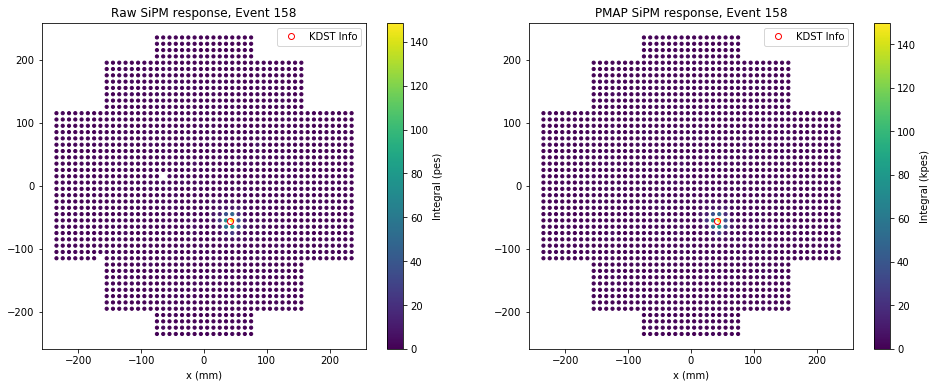

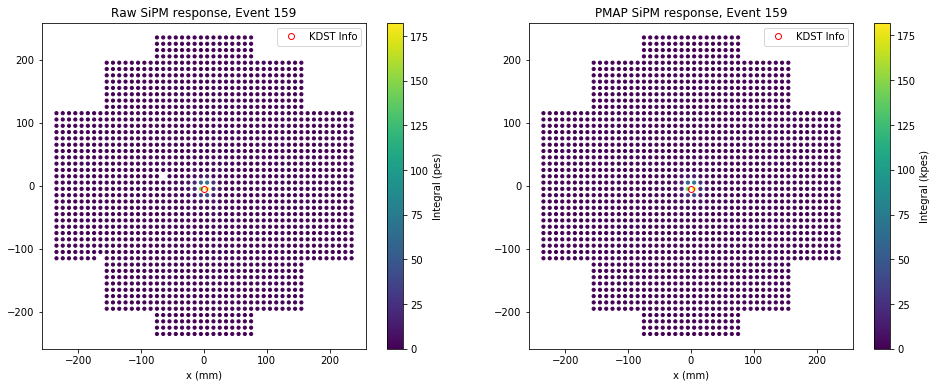

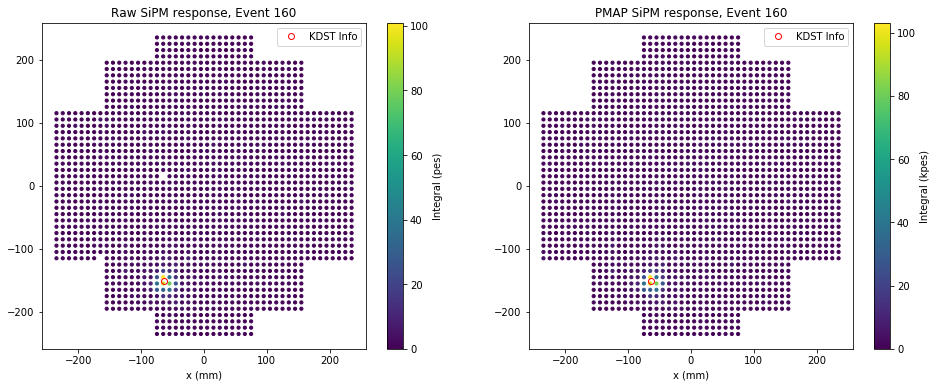

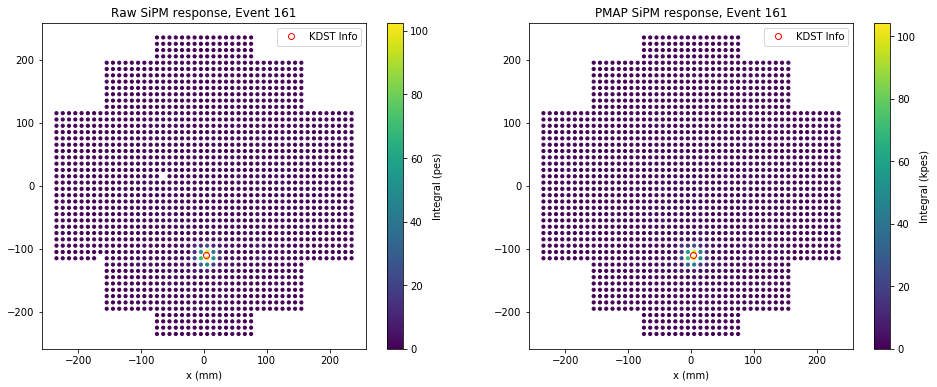

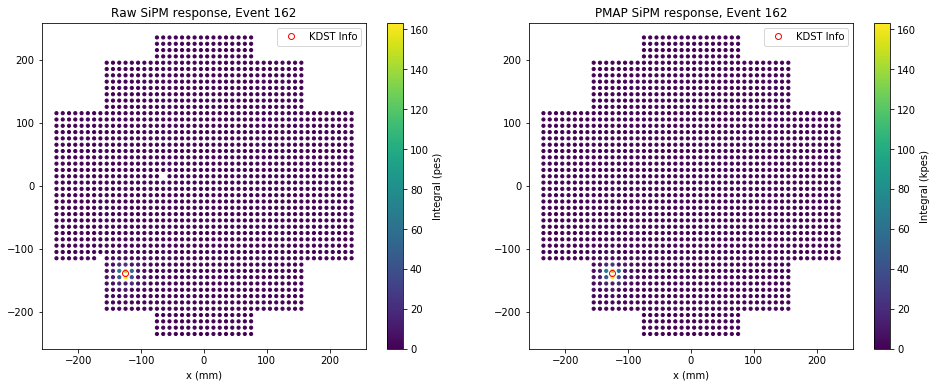

In [147]:
evt_start = pmap_events[0]
for evt in kdst_events[0:5]:

    # Plot raw waveform info
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(datasipm.X[raw_ids], datasipm.Y[raw_ids], s=10, c=sipms_s2_tsummed[evt-evt_start])
    plt.plot(kdst[kdst.event==evt].X, kdst[kdst.event==evt].Y, 'o', color='red', label='KDST Info',fillstyle='none')
    plt.legend()
    plt.xlabel("x (mm)")
    plt.colorbar().set_label("Integral (pes)")
    plt.title("Raw SiPM response, Event "+str(evt))

    # Plot PMAP info
    pmap = pmaps[evt]
    xys = sipm_xys[pmap.s2s[0].sipms.ids]
    plt.subplot(1, 2, 2)
    plt.scatter(dbsipm.X[pmap_ids], dbsipm.Y[pmap_ids], s=10, c=pmap.s2s[0].sipms.sum_over_times)
    plt.plot(kdst[kdst.event==evt].X, kdst[kdst.event==evt].Y, 'o', color='red', label='KDST Info',fillstyle='none')
    plt.legend()
    plt.xlabel("x (mm)")
    plt.colorbar().set_label("Integral (kpes)")
    plt.title("PMAP SiPM response, Event "+str(evt))

In [160]:
raw_evt_charge = np.sum(sipms_s2_tsummed, axis=1)
raw_outer_charge = np.sum(sipms_outer_tsummed, axis=1)

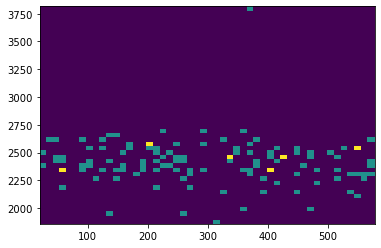

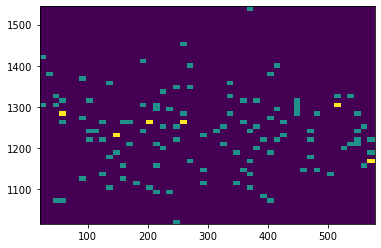

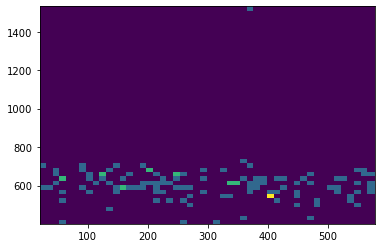

In [162]:
plt.hist2d(kdst.Z, raw_evt_charge[kdst_events - evt_start], bins=50)
plt.show()

plt.hist2d(kdst.Z, raw_outer_charge[kdst_events - evt_start], bins=50)
plt.show()

plt.hist2d(kdst.Z, kdst.S2q, bins=50)
plt.show()

In [183]:
k = ['../../data/trigger1/8088/kdsts/run_8088_trigger1_0_kdst.h5',
 '../../data/trigger1/8088/kdsts/run_8088_trigger1_1000_kdst.h5',
 '../../data/trigger1/8088/kdsts/run_8088_trigger1_2_kdst.h5']

r = ['../../data/trigger1/8088/run_8088_0001_trigger1_waveforms.h5',
 '../../data/trigger1/8088/run_8088_0002_trigger1_waveforms.h5',
 '../../data/trigger1/8088/run_8088_1000_trigger1_waveforms.h5']
k.sort(key=lambda file: int(file.split('_')[-2]))
r.sort(key=lambda file: int(file.split('_')[-3]))

In [184]:
k,r

(['../../data/trigger1/8088/kdsts/run_8088_trigger1_0_kdst.h5',
  '../../data/trigger1/8088/kdsts/run_8088_trigger1_2_kdst.h5',
  '../../data/trigger1/8088/kdsts/run_8088_trigger1_1000_kdst.h5'],
 ['../../data/trigger1/8088/run_8088_0001_trigger1_waveforms.h5',
  '../../data/trigger1/8088/run_8088_0002_trigger1_waveforms.h5',
  '../../data/trigger1/8088/run_8088_1000_trigger1_waveforms.h5'])

In [8]:
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import glob
import numpy as np
import tables as tb
import pandas as pd
import json
import sys

#from invisible_cities.evm import pmaps
from invisible_cities.io import pmaps_io, dst_io 
from invisible_cities.database.load_db  import DataPMT, DataSiPM
from invisible_cities.reco import xy_algorithms as xya
from invisible_cities.core import system_of_units as units
from invisible_cities.cities import components as cp


#from GetCharge import  GetCalibratedWaveforms

s2_bincenter = 802
outer_bincenter = 1000

fnum = 1
num_plots = 5
dbfile = 'new'

def GetEventStart(pmap_file):
    # Grab pmaps (for comparison)
    pmaps = pmaps_io.load_pmaps(pmap_file)
    pmap_events = list(pmaps.keys())
    evt_start = pmap_events[0]
    return evt_start, pmaps

def GetWindow(calibrated_sipms, s2_window, outer_window, kdst_events, evt_start, outfile=None):
    sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
    sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]
    s2_event_energy = np.sum(np.sum(sipms_s2, axis=2), axis=1)
    outer_event_energy = np.sum(np.sum(sipms_outer, axis=2), axis=1)
    #s2_event_energy = s2_event_energy[kdst_events - evt_start]
    #outer_event_energy = outer_event_energy[kdst_events - evt_start]

    if outfile:
        data = {'s2':s2_event_energy.tolist(), 'outer':outer_event_energy.tolist(), 'window':s2_window[1]-s2_window[0], 'events':kdst_events.tolist()}
        json.dump(data, open(outfile, 'w'))

    return s2_event_energy, outer_event_energy

def GetEventWindow(calibrated_sipms, s2_window, outer_window, kdst_events, evt_start, outfile=None):
    sipms_s2 = calibrated_sipms[:,s2_window[0]:s2_window[1]]
    sipms_outer = calibrated_sipms[:,outer_window[0]:outer_window[1]]
    s2_event_energy = np.sum(np.sum(sipms_s2, axis=1), axis=0)
    outer_event_energy = np.sum(np.sum(sipms_outer, axis=1), axis=0)
    #s2_event_energy = s2_event_energy[kdst_events - evt_start]
    #outer_event_energy = outer_event_energy[kdst_events - evt_start]

    #if outfile:
    #    data = {'s2':s2_event_energy.tolist(), 'outer':outer_event_energy.tolist(), 'window':s2_window[1]-s2_window[0], 'events':kdst_events.tolist()}
    #    json.dump(data, open(outfile, 'w'))

    return s2_event_energy, outer_event_energy

def GetSiPMs(run_number, calibrated_sipms, worst_sipms, s2_window, outer_window, kdst_events, evt_start):
    # Grab SiPM XY positions
    dbsipm   = DataSiPM(dbfile, run_number)
    sipm_xs    = dbsipm.X.values
    sipm_ys    = dbsipm.Y.values
    sipm_xys   = np.stack((sipm_xs, sipm_ys), axis=1)
    raw_ids = np.array([i for i in range(1792)])
    raw_ids = np.delete(raw_ids, worst_sipms)

    sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
    sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]
    sipms_s2 = np.sum(sipms_s2, axis=2)
    sipms_outer = np.sum(sipms_outer, axis=2)
    #sipms_outer = sipms_outer_tsummed[kdst_events - evt_start,:]
    #sipms_s2 = sipms_s2_tsummed[kdst_events - evt_start,:]

    return dbsipm, sipm_xys, raw_ids, sipms_s2, sipms_outer

def GetKDSTEvents(kdst_file):
    # Grap kdst info
    kdst = dst_io.load_dst(kdst_file, 'DST', 'Events')
    kdst = kdst[kdst.nS1==1]
    kdst = kdst[kdst.nS2==1]
    kdst_events = np.unique(kdst.event.to_numpy())
    return kdst, kdst_events

def PlotSameEvent(evt, dbsipm, raw_ids, sipms_s2_evt, kdst, pmap, sipm_xys, outputdir):
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(dbsipm.X[raw_ids], dbsipm.Y[raw_ids], s=10, c=sipms_s2_evt)
    plt.plot(kdst[kdst.event==evt].X, kdst[kdst.event==evt].Y, 'o', color='red', label='KDST Info',fillstyle='none')
    plt.legend()
    plt.xlabel("x (mm)")
    plt.colorbar().set_label("Integral (pes)")
    plt.title("Raw SiPM response, Event "+str(evt))

    # Plot PMAP info
    pmap_ids = pmap.s2s[0].sipms.ids
    xys = sipm_xys[pmap.s2s[0].sipms.ids]
    plt.subplot(1, 2, 2)
    plt.scatter(dbsipm.X[pmap_ids], dbsipm.Y[pmap_ids], s=10, c=pmap.s2s[0].sipms.sum_over_times)
    plt.plot(kdst[kdst.event==evt].X, kdst[kdst.event==evt].Y, 'o', color='red', label='KDST Info',fillstyle='none')
    plt.legend()
    plt.xlabel("x (mm)")
    plt.colorbar().set_label("Integral (kpes)")
    plt.title("PMAP SiPM response, Event "+str(evt))
    #plt.savefig(outputdir+'matchevent'+str(evt)+'.png')
    plt.show()
    return



def Plot_ZvQ(kdst, s2_event_energy, outer_event_energy, evt_start, outputdir):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.hist2d(kdst.Z, s2_event_energy, bins=50)
    plt.xlabel('Z [mm]')
    plt.ylabel('Q [pes]')
    plt.title('S2 window')

    plt.subplot(1, 3, 2)
    plt.hist2d(kdst.Z, outer_event_energy, bins=50)
    plt.xlabel('Z [mm]')
    plt.ylabel('Q [pes]')
    plt.title('Outer window')

    plt.subplot(1, 3, 3)
    plt.hist2d(kdst.Z, s2_event_energy - outer_event_energy, bins=50)
    plt.xlabel('Z [mm]')
    plt.ylabel('Q [pes]')
    plt.title('S2 - Outer window')
    plt.savefig(outputdir+'ZvQ.png')
    return

def GetFileName(file_base, file_end, trigger, file_num, raw=False):

    if raw:
        fnum = ''
        for _ in range(0,4-len(str(filenum))): fnum+='0'
        fnum += str(filenum)
        file_name = file_base + fnum + '_' + trigger + file_end #'_waveforms.h5'
    else:
        file_name = file_base + trigger + '_' + file_num + file_end

    return file_name
 

In [9]:
filenum = '0'
run_number = 8088
datadir = '../../data/trigger1/8088/'
window = 10
trigger = 'trigger1'
outputdir = ''
outfile = None

# Get file names and directory
file_name = GetFileName(datadir+'waveforms/run_'+str(run_number)+'_', '_waveforms.h5', trigger, filenum, raw=True) # Files named run_{run_number}_{fnum}_trigger1_waveforms.h5
pmap_file = GetFileName(datadir+'pmaps/run_'+str(run_number)+'_', '_pmaps.h5', trigger, filenum) # Files named run_{run_number}_trigger1_{fnum}_pmaps.h5
kdst_file = GetFileName(datadir+'kdsts/sthresh/run_'+str(run_number)+'_', '_kdst.h5', trigger, filenum) # Files named run_{run_number}_trigger1_{fnum}_kdsts.h5
print('raw file', file_name)
print('pmap', pmap_file)
print('kdst', kdst_file)


raw file ../../data/trigger1/8088/waveforms/run_8088_0000_trigger1_waveforms.h5
pmap ../../data/trigger1/8088/pmaps/run_8088_trigger1_0_pmaps.h5
kdst ../../data/trigger1/8088/kdsts/sthresh/run_8088_trigger1_0_kdst.h5


In [10]:
file = tb.open_file(file_name)
events_map = dst_io.load_dst(file_name, "Run", "events")
# Get raw waveform, pmap, and kdst info
calibrated_sipms, worst_sipms = GetCalibratedWaveforms(run_number, file_name)
evt_start, pmaps = GetEventStart(pmap_file)

Number of Events: 156


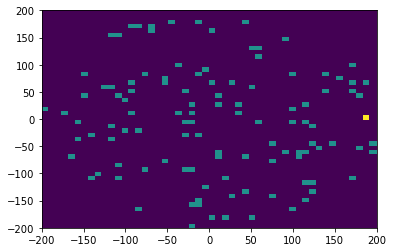

In [11]:
kdst, kdst_events = GetKDSTEvents(kdst_file)
plt.hist2d(kdst.X, kdst.Y, bins=50, range=[(-200,200),(-200,200)])
plt.show()

In [12]:
# Get raw waveform, pmap, and kdst info
calibrated_sipms, worst_sipms = GetCalibratedWaveforms(run_number, file_name)
evt_start, pmaps = GetEventStart(pmap_file)
kdst, kdst_events = GetKDSTEvents(kdst_file)

events_map = dst_io.load_dst(file_name, "Run", "events").evt_number.to_numpy()
events_dict = {events_map[i]:i for i in range(len(events_map))}
raw_good_events = [events_dict[evt] for evt in kdst_events]
calibrated_sipms = calibrated_sipms[raw_good_events,:,:]

s2_window = [int(s2_bincenter - (window/2.)), int(s2_bincenter + (window/2.))]
outer_window = [int(outer_bincenter - (window/2.)), int(outer_bincenter + (window/2.))]
s2_event_energy, outer_event_energy = GetWindow(calibrated_sipms, s2_window, outer_window, kdst_events, evt_start, outfile=outfile)


Number of Events: 156


(114, 1790) (114,)


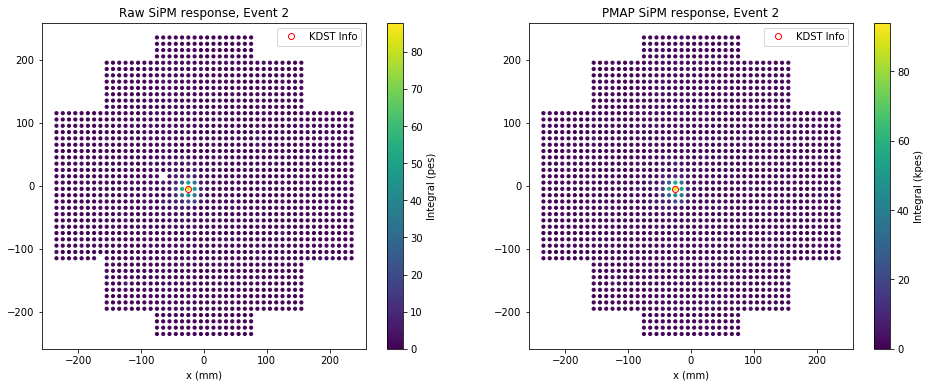

(114, 1790) (114,)


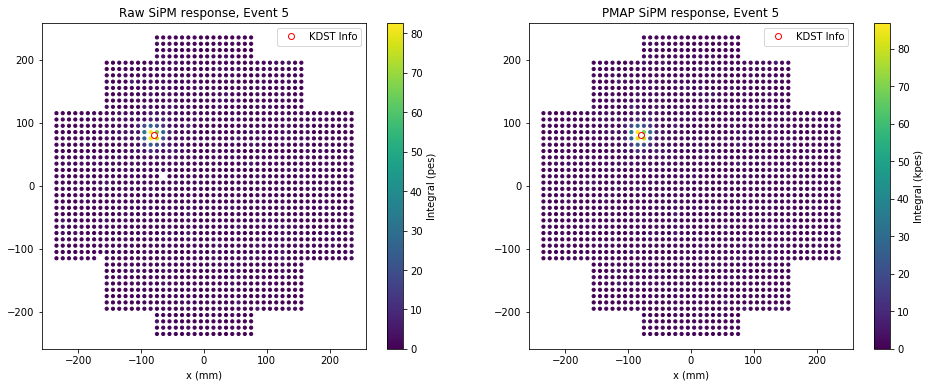

(114, 1790) (114,)


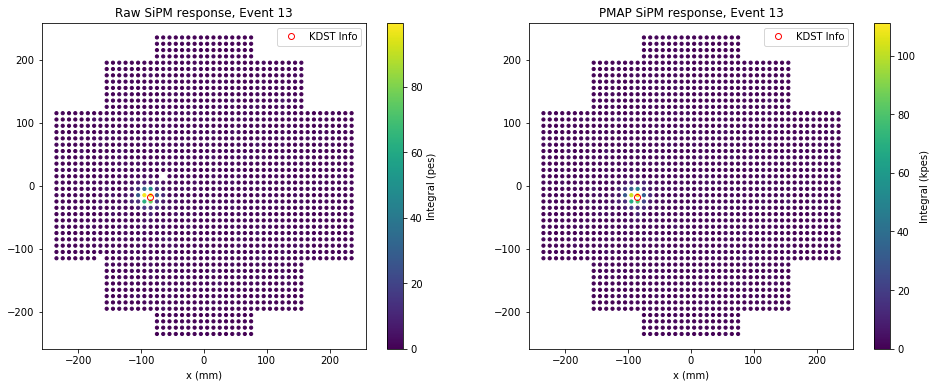

In [13]:
# File num = 0
events = [0, 2, 10]
for base_evt in events:
    # Plot individual events to check match
    evt = kdst_events[base_evt]
    dbsipm, sipm_xys, raw_ids, sipms_s2, sipms_outer = GetSiPMs(run_number, calibrated_sipms, worst_sipms, s2_window, outer_window, kdst_events, evt_start)
    print(np.shape(sipms_s2), np.shape(kdst_events))

    PlotSameEvent(evt, dbsipm, raw_ids, sipms_s2[base_evt,:], kdst, pmaps[evt], sipm_xys, outputdir)


# Test varying window

In [25]:
def windowfunc(z):
    return 0.39 * np.sqrt(z) + 3.821 

In [26]:
kdst.Z

0      446.148132
10     128.132187
11     290.724640
12     367.299957
13     410.551514
          ...    
156    435.823700
157    119.197380
158    506.146912
159    473.923828
160    403.814972
Name: Z, Length: 114, dtype: float64

In [27]:
np.shape(calibrated_sipms)

(114, 1790, 1600)

In [28]:
zs = kdst.Z.to_list()
windows = windowfunc(zs)
s2_energies = []
outer_energies = []
for evt in range(len(zs)):
    s2_window = [int(s2_bincenter - (windows[evt]/2.)), int(s2_bincenter + (windows[evt]/2.))]
    outer_window = [int(outer_bincenter - (windows[evt]/2.)), int(outer_bincenter + (windows[evt]/2.))]
    s2_event_energy, outer_event_energy = GetEventWindow(calibrated_sipms[evt,:,:], s2_window, outer_window, kdst_events, evt_start, outfile=outfile)
    s2_energies.append(s2_event_energy)
    outer_energies.append(outer_event_energy)
    
s2_energies = np.array(s2_energies)
outer_energies = np.array(outer_energies)

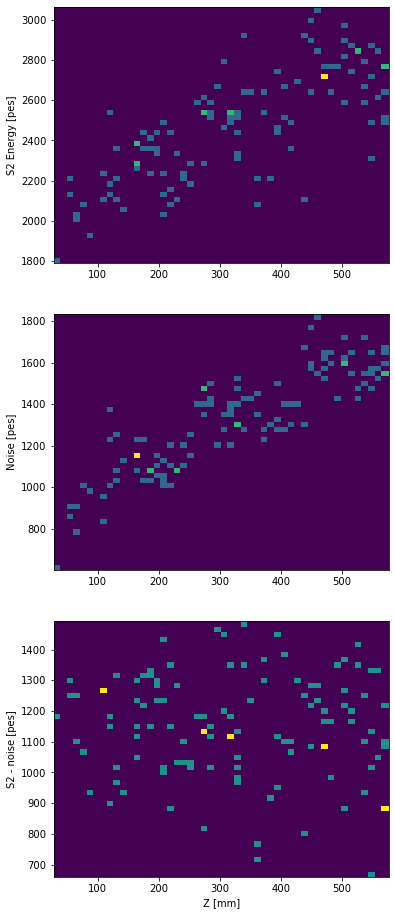

In [32]:
plt.figure(figsize=(6, 16))
plt.subplot(3,1,1)
plt.hist2d(zs, s2_energies, bins=50)
plt.ylabel('S2 Energy [pes]')

plt.subplot(3,1,2)
plt.hist2d(zs, outer_energies, bins=50)
plt.ylabel('Noise [pes]')

plt.subplot(3,1,3)
plt.hist2d(zs, s2_energies-outer_energies, bins=50)
plt.ylabel('S2 - noise [pes]')
plt.xlabel('Z [mm]')
plt.show()

In [38]:
ave_noise = np.mean(outer_energies, axis=1)
ave_signal = np.mean(s2_energies, axis=1)

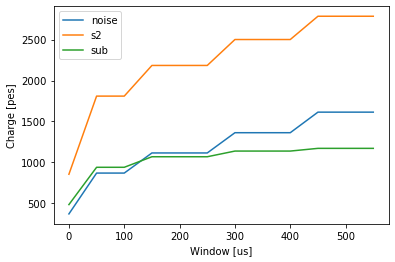

In [42]:
plt.plot(zs, ave_noise, label='noise')
plt.plot(zs, ave_signal, label='s2')
plt.plot(zs, ave_signal-ave_noise, label='sub')
plt.legend()
plt.xlabel('Window [us]')
plt.ylabel('Charge [pes]')
plt.show()

# Test multiple files and events

raw file ../../data/trigger1/8088/waveforms/run_8088_0000_trigger1_waveforms.h5
pmap ../../data/trigger1/8088/pmaps/run_8088_trigger1_0_pmaps.h5
kdst ../../data/trigger1/8088/kdsts/sthresh/run_8088_trigger1_0_kdst.h5
Number of Events: 156
File num = 0
(114, 1790) (114,)


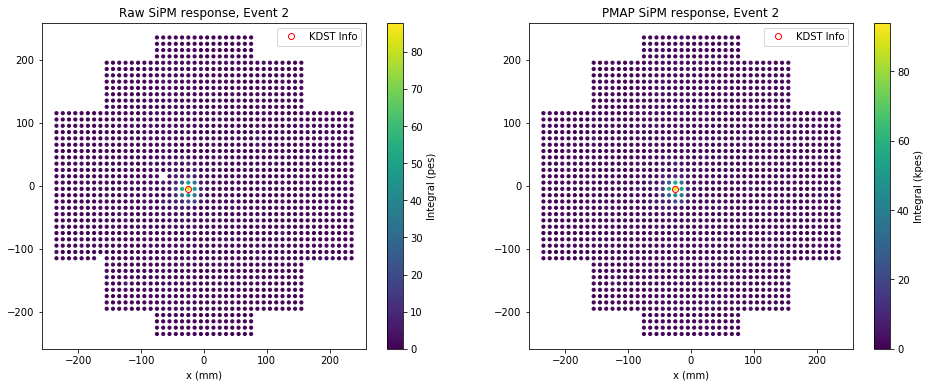

(114, 1790) (114,)


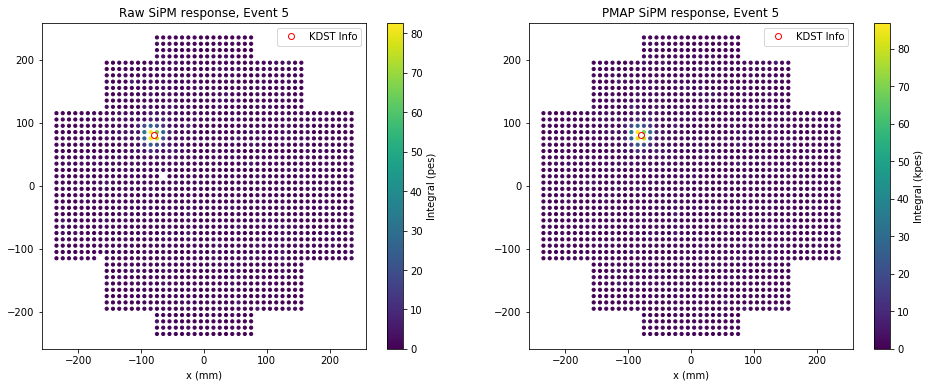

(114, 1790) (114,)


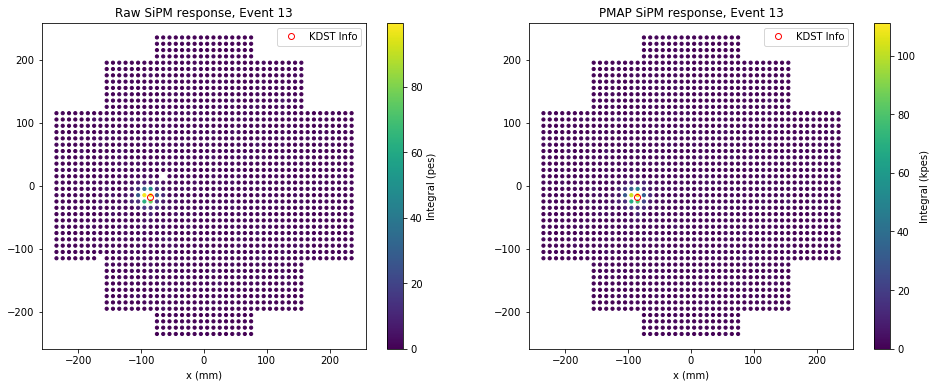

raw file ../../data/trigger1/8088/waveforms/run_8088_0001_trigger1_waveforms.h5
pmap ../../data/trigger1/8088/pmaps/run_8088_trigger1_1_pmaps.h5
kdst ../../data/trigger1/8088/kdsts/sthresh/run_8088_trigger1_1_kdst.h5
Number of Events: 156
File num = 1
(120, 1790) (120,)


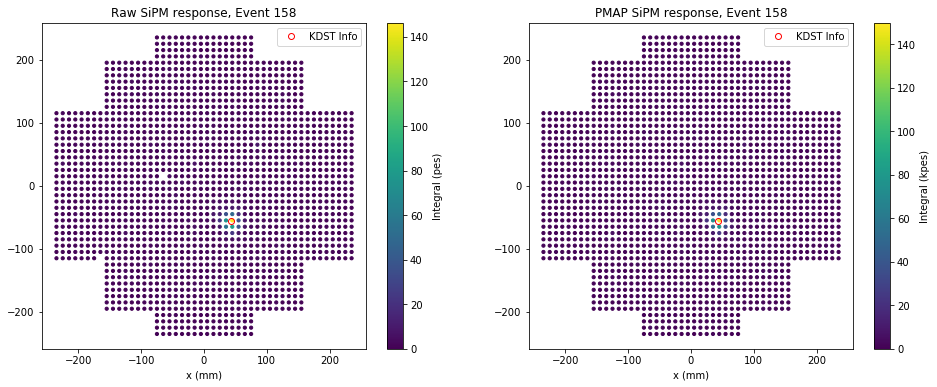

(120, 1790) (120,)


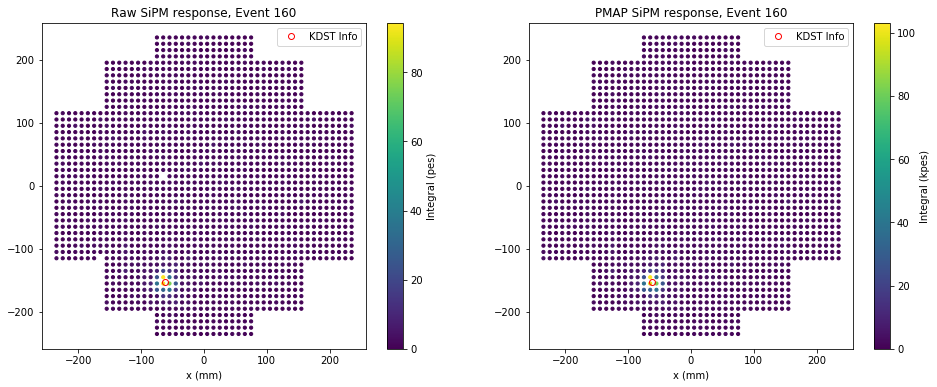

(120, 1790) (120,)


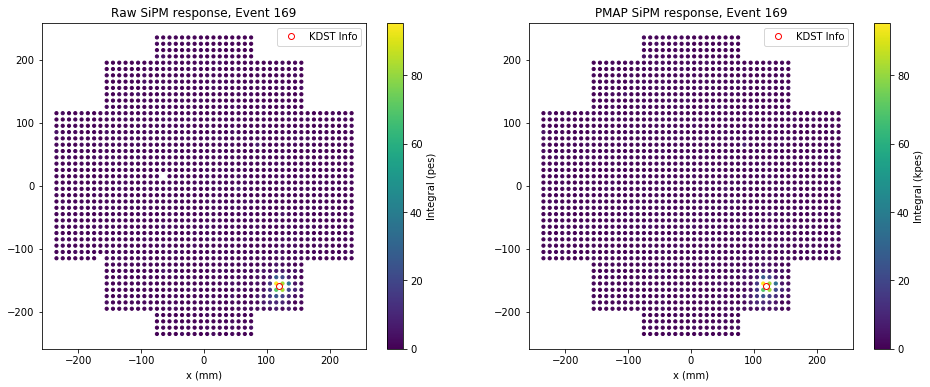

raw file ../../data/trigger1/8088/waveforms/run_8088_0929_trigger1_waveforms.h5
pmap ../../data/trigger1/8088/pmaps/run_8088_trigger1_929_pmaps.h5
kdst ../../data/trigger1/8088/kdsts/sthresh/run_8088_trigger1_929_kdst.h5
Number of Events: 153
File num = 929
(111, 1790) (111,)


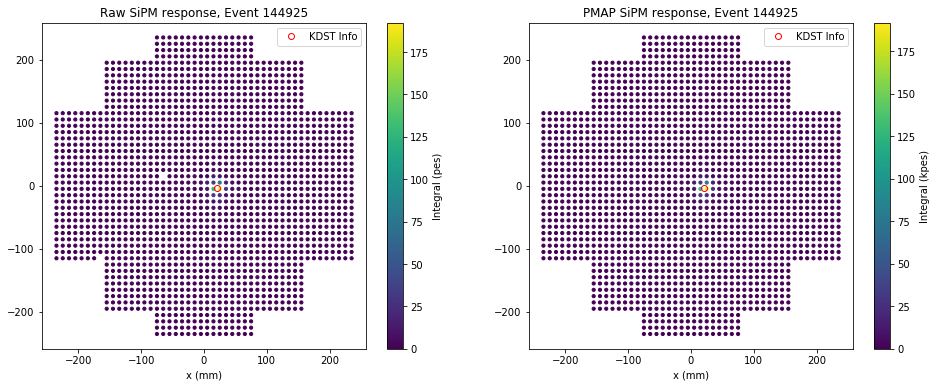

(111, 1790) (111,)


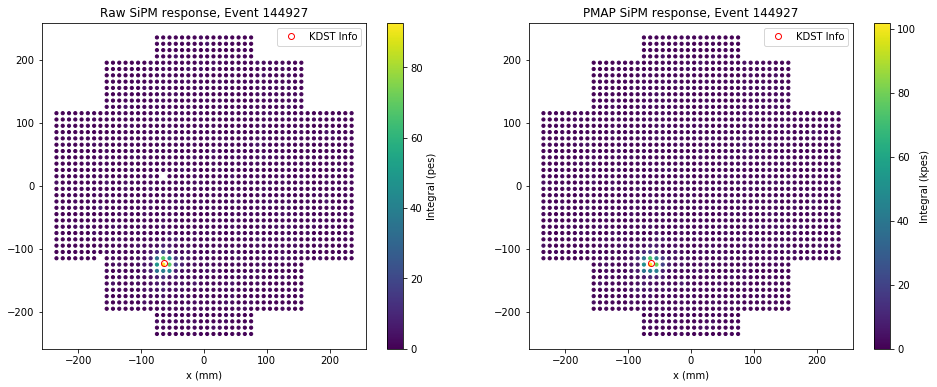

(111, 1790) (111,)


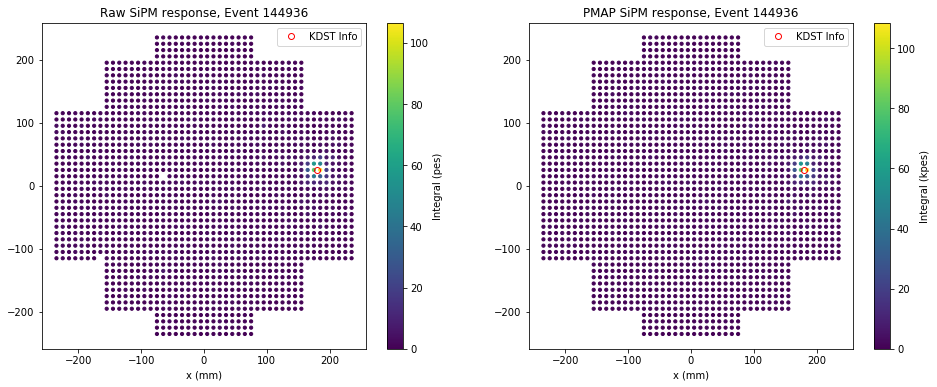

In [79]:
filenums = ['0','1','929']
for filenum in filenums:
    run_number = 8088
    datadir = '../../data/trigger1/8088/'
    window = 10
    trigger = 'trigger1'
    outputdir = ''
    outfile = None

    # Get file names and directory
    file_name = GetFileName(datadir+'waveforms/run_'+str(run_number)+'_', '_waveforms.h5', trigger, filenum, raw=True) # Files named run_{run_number}_{fnum}_trigger1_waveforms.h5
    pmap_file = GetFileName(datadir+'pmaps/run_'+str(run_number)+'_', '_pmaps.h5', trigger, filenum) # Files named run_{run_number}_trigger1_{fnum}_pmaps.h5
    kdst_file = GetFileName(datadir+'kdsts/sthresh/run_'+str(run_number)+'_', '_kdst.h5', trigger, filenum) # Files named run_{run_number}_trigger1_{fnum}_kdsts.h5
    print('raw file', file_name)
    print('pmap', pmap_file)
    print('kdst', kdst_file)
    
    # Get raw waveform, pmap, and kdst info
    calibrated_sipms, worst_sipms = GetCalibratedWaveforms(run_number, file_name)
    evt_start, pmaps = GetEventStart(pmap_file)
    kdst, kdst_events = GetKDSTEvents(kdst_file)

    events_map = dst_io.load_dst(file_name, "Run", "events").evt_number.to_numpy()
    events_dict = {events_map[i]:i for i in range(len(events_map))}
    raw_good_events = [events_dict[evt] for evt in kdst_events]
    calibrated_sipms = calibrated_sipms[raw_good_events,:,:]

    s2_window = [int(s2_bincenter - (window/2.)), int(s2_bincenter + (window/2.))]
    outer_window = [int(outer_bincenter - (window/2.)), int(outer_bincenter + (window/2.))]
    s2_event_energy, outer_event_energy = GetWindow(calibrated_sipms, s2_window, outer_window, kdst_events, evt_start, outfile=outfile)

    print('File num = '+filenum)
    events = [0, 2, 10]
    for base_evt in events:
        # Plot individual events to check match
        evt = kdst_events[base_evt]
        dbsipm, sipm_xys, raw_ids, sipms_s2, sipms_outer = GetSiPMs(run_number, calibrated_sipms, worst_sipms, s2_window, outer_window, kdst_events, evt_start)
        print(np.shape(sipms_s2), np.shape(kdst_events))

        PlotSameEvent(evt, dbsipm, raw_ids, sipms_s2[base_evt,:], kdst, pmaps[evt], sipm_xys, outputdir)


# Testing Noise subtraction

In [23]:
kdst.S2t

0      804473.1250
10     802507.1875
11     803474.6250
12     802499.9375
13     803476.5000
          ...     
156    802498.6875
157    802497.3750
158    804471.8750
159    803473.8125
160    803489.9375
Name: S2t, Length: 114, dtype: float64

Text(0, 0.5, 'Average Noise [pes]')

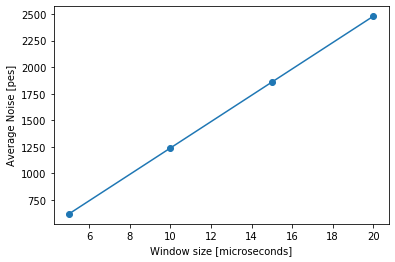

In [5]:
noise = np.array([619, 1239, 1859, 2479])
window = np.array([5, 10,15,20])
plt.plot(window, noise, '-o')
plt.xlabel('Window size [microseconds]')
plt.ylabel('Average Noise [pes]')

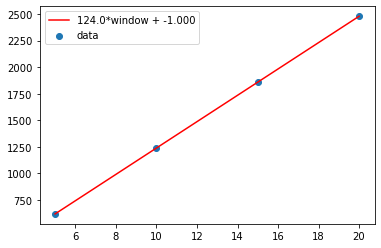

In [6]:
a, b = np.polyfit(window, noise, 1)
#add points to plot
plt.scatter(window, noise, label='data')

#add line of best fit to plot
plt.plot(window, a*window+b, color='r',label="{:#.4g}*window + {:#.4}".format(a,b))
plt.legend()

Text(0, 0.5, 'Average Noise [pes]')

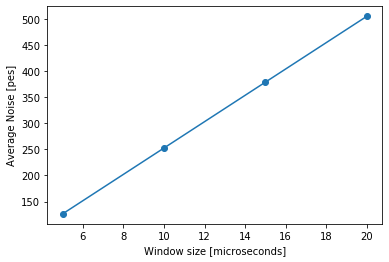

In [2]:
zs_noise = np.array([126.3, 252.6, 378.9, 505.1])
window = np.array([5, 10,15,20])
plt.plot(window, zs_noise, '-o')
plt.xlabel('Window size [microseconds]')
plt.ylabel('Average Noise [pes]')

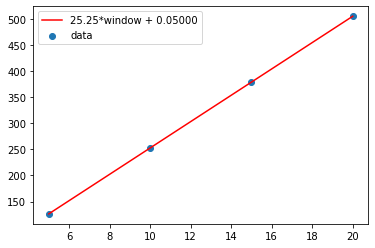

In [4]:
zs_a, zs_b = np.polyfit(window, zs_noise, 1)
#add points to plot
plt.scatter(window, zs_noise, label='data')

#add line of best fit to plot
plt.plot(window, zs_a*window+zs_b, color='r',label="{:#.4g}*window + {:#.4}".format(zs_a,zs_b))
plt.legend()

Text(0, 0.5, 'Mean noise [pes]')

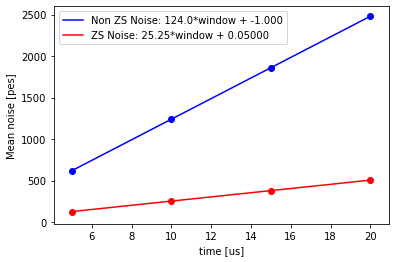

In [8]:
plt.scatter(window, noise, color='b')
plt.plot(window, a*window+b, color='b',label="Non ZS Noise: {:#.4g}*window + {:#.4}".format(a,b))


plt.scatter(window, zs_noise, color='r')
plt.plot(window, zs_a*window+zs_b, color='r',label="ZS Noise: {:#.4g}*window + {:#.4}".format(zs_a,zs_b))
plt.legend()
plt.xlabel('time [us]')
plt.ylabel('Mean noise [pes]')

In [9]:
noise/window

array([123.8       , 123.9       , 123.93333333, 123.95      ])